<a href="https://colab.research.google.com/github/bhernandeza5/Challenge_TelecomX/blob/main/challenge_telecom_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom parte 2 Latam



## Subir el archivo tratado en la parte 1

In [1]:
import pandas as pd

# Subir archivo manualmente
from google.colab import files
uploaded = files.upload()

# Leer el CSV
df = pd.read_csv("telecom_tratado.csv")
df.head()


Saving telecom_tratado.csv to telecom_tratado.csv


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias,Servicios_Activos
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667,5
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667,3
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333,3
3,0011-IGKFF,1,Male,1,Yes,No,13,Yes,No,Fiber optic,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667,6
4,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,No,Fiber optic,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667,4


## Eliminar columnas que no aportan valor

In [2]:
# Eliminar columnas irrelevantes
df = df.drop(columns=["customerID"])

print("✅ Columnas eliminadas: customerID")
print("Columnas actuales:", df.columns.tolist())


✅ Columnas eliminadas: customerID
Columnas actuales: ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias', 'Servicios_Activos']


In [3]:
# Separar variables categóricas y numéricas
cat_cols = df.select_dtypes(include="object").columns.tolist()
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numeric columns: ['Churn', 'SeniorCitizen', 'tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias', 'Servicios_Activos']


## One Hot Encoder

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Columnas categóricas
cat_cols = df.select_dtypes(include="object").columns.tolist()

# Separar target
y = df["Churn"]
X = df.drop(columns=["Churn"])

# Definir transformador
ct = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(drop="first"), cat_cols)],
    remainder="passthrough"
)

X_encoded = ct.fit_transform(X)

print("Shape transformado:", X_encoded.shape)

'''ColumnTransformer aplica OneHot a las columnas categóricas y deja pasar las
numéricas.
drop = 'first' evita la multicolinealidad
x_encoded = sparse (dispersa), ahorra memoria
y = etiqueta binaria 0 no churn, 1 churn'''


Shape transformado: (7043, 32)


## Proporción de clases en Churn

In [5]:
# Distribución de la variable objetivo
churn_counts = y.value_counts()
churn_proportion = y.value_counts(normalize=True) * 100

print("Conteo de clientes por clase:")
print(churn_counts)
print("\nProporción (%) de clientes por clase:")
print(churn_proportion)


Conteo de clientes por clase:
Churn
0    5174
1    1869
Name: count, dtype: int64

Proporción (%) de clientes por clase:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


### Resultado:

* 5174 clientes (73.5%) permanecieron en la empresa.

* 1869 clientes (26.5%) cancelaron.

Existe un desbalance moderado: ~3 de cada 4 clientes permanecen, y 1 de cada 4 cancela.

Un modelo “ingenuo” que siempre prediga “no canceló” tendría 73% de accuracy, pero no detectaría a ningún cliente que sí cancela (recall=0).

Por eso, **accuracy** no es suficiente como métrica en este caso.

Habrá que enfocarse en **recall, precision, F1-score y ROC-AUC.**

## Balanceo, normalización y comparación de métricas

###Opciones para balanceo de los datos:
1. Sin balanceo: baseline
2. lass_weight="balanced" en modelos como RandomForest, XGBoost y Regresión logistica, etc
3. SMOTE

In [12]:
RANDOM_STATE = 42 #Semilla a usar
#Dividir el train/test
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_encoded, y.astype(int),
    test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

''' Separamos los datos en train y test, y usamos stratify=y para mantener la
proporción 0/1 en los sets de train y test, lo cual es util cuando hay
desbalance.'''

' Separamos los datos en train y test, y usamos stratify=y para mantener la\nproporción 0/1 en los sets de train y test, lo cual es util cuando hay\ndesbalance.'

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

'''StandarScaler, para reescalar las variables numéricas y ponerlas en la
misma escala, util en modelos como RL, SVM, KNN o Redes Neuronales'''
scaler = StandardScaler(with_mean=False)
 # importante: X puede ser sparse
 # with_mean=False ya que no se puede restar la media en la matriz sparse

'''Modelo Regresión logística: LR basado en pesos/distancias REQUIERE
ESCALADO'''
logreg = LogisticRegression(max_iter=1000, random_state=42)

'''Modelo Random Forest: RF NO REQUIERE ESCALADO'''
rf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

In [11]:
#Importe de librerías necesarias
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)

from imblearn.over_sampling import SMOTE, RandomOverSampler  # (ROS por si prefieres alternar)
RANDOM_STATE = 42 #Semilla a usar

In [14]:
''' Caso 1: Baseline sin balancear'''
from sklearn.pipeline import Pipeline

#LR: Escala y luego entrena
pipe_lr_base = Pipeline([
    ("scaler", scaler), #paso de normalización
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
]) #LogisticRegressionClassifier

#RF: Entrena (no escala)
pipe_rf_base = Pipeline([
    ("clf", rf)
])

pipe_lr_base.fit(X_tr, y_tr)
pipe_rf_base.fit(X_tr, y_tr)


Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])

In [15]:
'''Caso 2: Balancear con class_weight="balanced"'''
#LR: Escala y luego entrena CW: le dice al modelo la clase minoritaria vale
pipe_lr_cw = Pipeline([
    ("scaler", scaler),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

#RF: Entrena (no escala)  CW: le dice al modelo la clase minoritaria vale
pipe_rf_cw = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=400, class_weight="balanced",
                                   n_jobs=-1, random_state=42))
])

pipe_lr_cw.fit(X_tr, y_tr)
pipe_rf_cw.fit(X_tr, y_tr)

''' Ventaja: No cambia los datos, solo el costo del modelo
Desventajas: Sube recall y baja precision'''

' Ventaja: No cambia los datos, solo el costo del modelo\nDesventajas: Sube recall y baja precision'

In [16]:
''' Caso 3: SMOTE (synthetic minority oversampling technique)'''
#SMOTE NO ACEPTA MATRICES SPARSE -> Se densifica lo necesario
from imblearn.over_sampling import SMOTE

# 1) pasar train (y opcionalmente test) a denso para SMOTE
X_tr_dense = X_tr.toarray() if hasattr(X_tr, "toarray") else X_tr
X_te_dense = X_te.toarray() if hasattr(X_te, "toarray") else X_te

# 2) aplicar SMOTE *solo* en TRAIN
sm = SMOTE(random_state=42, k_neighbors=5)
X_tr_sm, y_tr_sm = sm.fit_resample(X_tr_dense, y_tr)

''' SMOTE genera nuevos ejemplos de la clase 1 combinando vecinos, NUNCA SE
TOCA EL TEST'''

#ENTRENAR EL MODELO
# LR con escalado
pipe_lr_smote = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])
pipe_lr_smote.fit(X_tr_sm, y_tr_sm)

# RF sin escalado
pipe_rf_smote = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42))
])
pipe_rf_smote.fit(X_tr_sm, y_tr_sm)


Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=400, n_jobs=-1,
                                        random_state=42))])

Otra opción que sí acepta SPARSE es **RandomOverSampler**

In [17]:
'''Función de evaluación (calculo de métricas)'''
#Importe de todas las metricas relevantes
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

def eval_pipeline(nombre_esc, nombre_modelo, pipe, X_te, y_te):
    # Probabilidades o “scores”
    y_score = (pipe.predict_proba(X_te)[:, 1]
               if hasattr(pipe[-1], "predict_proba")
               else pipe.decision_function(X_te))

    # Umbral 0.5 para convertir prob → clase
    y_pred = (y_score >= 0.5).astype(int)

    # Matriz de confusión
    cm = confusion_matrix(y_te, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Métricas clave
    metrics = {
        "scenario": nombre_esc,
        "model": nombre_modelo,
        "accuracy": accuracy_score(y_te, y_pred),
        "precision_1": precision_score(y_te, y_pred, pos_label=1, zero_division=0),
        "recall_1": recall_score(y_te, y_pred, pos_label=1),
        "f1_1": f1_score(y_te, y_pred, pos_label=1),
        "roc_auc": roc_auc_score(y_te, y_score),
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }
    return metrics

Qué da cada métrica:
1. **Accuracy**: aciertos totales (puede engañar con desbalance).

2. **Precision_1**: de los que predije churn, ¿cuántos sí eran churn?

3. **Recall_1**: de los que eran churn, ¿cuántos detecté? (negocios suelen priorizarlo).

4. **F1_1**: equilibrio entre precisión y recall (buena métrica resumen).

5. **ROC AUC**: capacidad global de separar 0 vs 1 independiente del umbral.

In [18]:
'''Resumen comparativo'''
# tras evaluar cada pipeline:
summary = pd.DataFrame(results).sort_values(by=["roc_auc", "f1_1"], ascending=False)
display(summary)


,scenario,model,accuracy,precision_1,recall_1,f1_1,roc_auc,tn,fp,fn,tp
2,ClassWeight,LogReg,0.740241,0.506920,0.783422,0.615546,0.843312,750,285,81,293
0,Baseline,LogReg,0.794180,0.637255,0.521390,0.573529,0.843157,924,111,179,195
4,SMOTE,LogReg,0.748048,0.516579,0.791444,0.625132,0.842056,758,277,78,296
3,ClassWeight,RandomForest,0.785664,0.631387,0.462567,0.533951,0.825557,934,101,201,173
1,Baseline,RandomForest,0.789212,0.635088,0.483957,0.549317,0.825431,931,104,193,181
5,SMOTE,RandomForest,0.786373,0.615873,0.518717,0.563135,0.824245,914,121,180,194


### Análisis de los resultados:

Comparación directa:

####Logistic Regression (con balanceo, SMOTE o ClassWeight)

* Recall ≈ 0.78–0.79 → detecta ~8 de cada 10 churners.

* F1 ≈ 0.62 → buen equilibrio entre precision y recall.

* ROC AUC ≈ 0.84 → muy buena discriminación.

####Random Forest (cualquier escenario)

* Recall ≈ 0.46–0.52 → detecta solo 5 de cada 10 churners.

* F1 ≈ 0.54–0.56 → peor balance.

* ROC AUC ≈ 0.82 → también bueno, pero un poco menor que LR.

### Conclusión estratégica:
El **mejor modelo es Logistic Regression con SMOTE (o ClassWeight)**.
- Este modelo logra un **recall cercano al 80%**, es decir, identifica a 8 de cada 10 clientes que cancelan.
- Aunque tiene más falsos positivos (precision ~0.51), **es preferible para el negocio** porque:
  - Prevenir la pérdida de un cliente es más valioso que revisar casos adicionales.
  - Permite priorizar estrategias de retención (ofertas, atención personalizada) en clientes con mayor probabilidad de churn.

## Análisis de correlación en variables numéricas

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


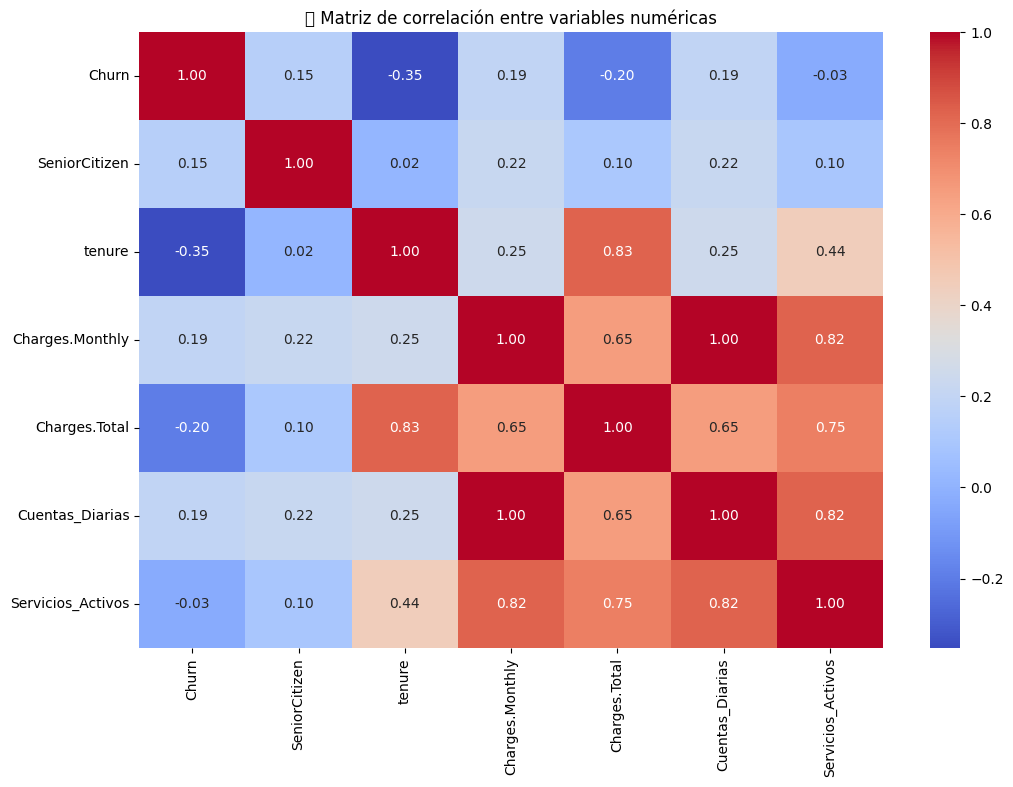

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación
corr_matrix = df[num_cols].corr()

# Visualizar
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("🔗 Matriz de correlación entre variables numéricas")
plt.show()


In [20]:
''' Correlación directa con Churn '''
# Correlación con la variable objetivo Churn
churn_corr = corr_matrix["Churn"].sort_values(ascending=False)

print("Correlación de variables numéricas con Churn:")
print(churn_corr)


Correlación de variables numéricas con Churn:
Churn                1.000000
Charges.Monthly      0.193356
Cuentas_Diarias      0.193356
SeniorCitizen        0.150889
Servicios_Activos   -0.030765
Charges.Total       -0.199037
tenure              -0.352229
Name: Churn, dtype: float64


### 🔗 Análisis de correlación con la variable Churn

#### 1. Variables con correlación positiva
- **Charges.Monthly (0.19)**: clientes con cargos mensuales más altos tienen mayor probabilidad de cancelar.  
- **Cuentas_Diarias (0.19)**: más cuentas diarias también se asocian con mayor riesgo de churn.  
- **SeniorCitizen (0.15)**: los clientes mayores muestran mayor tendencia a cancelar.

#### 2. Variables con correlación negativa
- **tenure (-0.35)**: la antigüedad es la variable con mayor correlación negativa; clientes que llevan más tiempo tienden a permanecer.  
- **Charges.Total (-0.19)**: un gasto acumulado mayor se relaciona con menor probabilidad de cancelación.  
- **Servicios_Activos (-0.03)**: la relación es muy débil, por lo que su efecto es casi nulo.

#### 3. Conclusión
- La variable más relevante es **tenure**, seguida de **Charges.Monthly / Cuentas_Diarias** y **SeniorCitizen**.  
- Estos resultados sugieren que el perfil típico de un cliente en riesgo de cancelación es:  
  - Cliente **nuevo** (tenure bajo).  
  - Con **cargos mensuales altos**.  
  - Y en el caso de clientes mayores, hay una ligera mayor propensión a cancelar.  
- Por el contrario, **clientes antiguos y con alta facturación acumulada son más leales**.


### Visualización de la relación de variables con churn

/tmp/ipython-input-3766213212.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="tenure", data=df, palette="Set2")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9203 (\N{HOURGLASS WITH FLOWING SAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


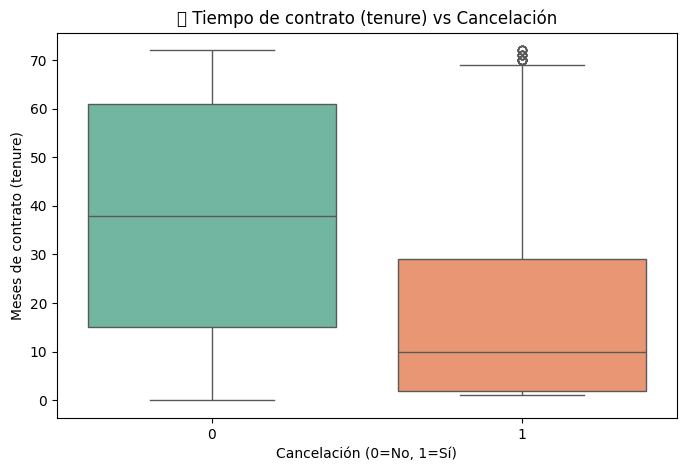

In [21]:
''' Distribución de la antiguedad (ternure)'''
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="tenure", data=df, palette="Set2")
plt.title("⏳ Tiempo de contrato (tenure) vs Cancelación")
plt.xlabel("Cancelación (0=No, 1=Sí)")
plt.ylabel("Meses de contrato (tenure)")
plt.show()


/tmp/ipython-input-4001809802.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="Charges.Total", data=df, palette="Set1")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


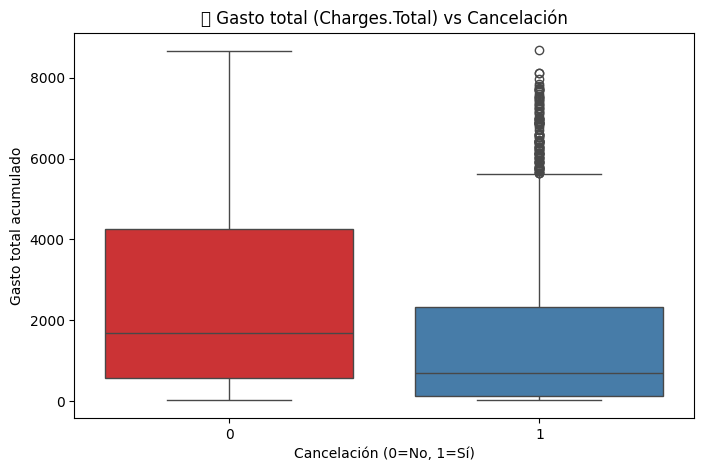

In [22]:
'''Gasto total vs Churn'''
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="Charges.Total", data=df, palette="Set1")
plt.title("💰 Gasto total (Charges.Total) vs Cancelación")
plt.xlabel("Cancelación (0=No, 1=Sí)")
plt.ylabel("Gasto total acumulado")
plt.show()


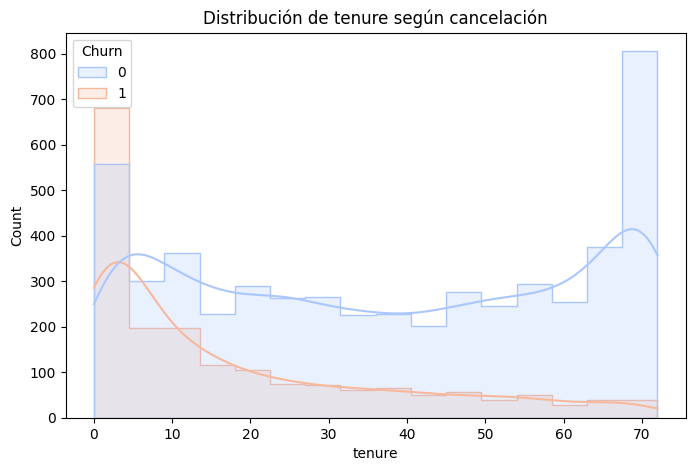

In [26]:
''' Distribución de churn vs ternure'''
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="tenure", hue="Churn", kde=True, palette="coolwarm", element="step")
plt.title("Distribución de tenure según cancelación")
plt.show()

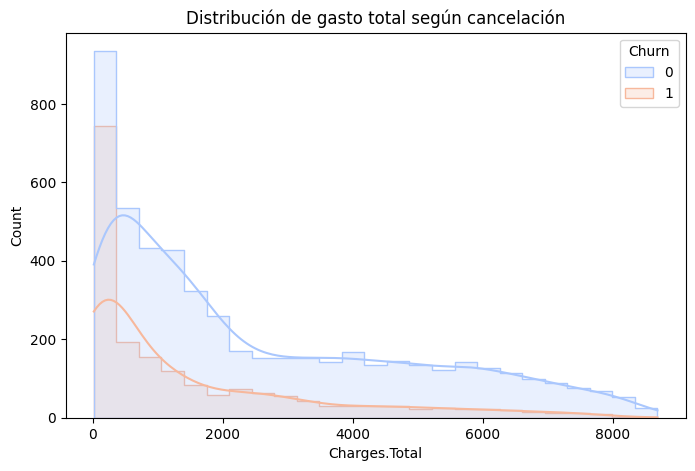

In [28]:
''' Distribución de churn vs Charges.Total'''
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="Charges.Total", hue="Churn", kde=True, palette="coolwarm", element="step")
plt.title("Distribución de gasto total según cancelación")
plt.show()

## Comparación con otros modelos

Ya comparamos **Logistic Regression** y **Random Forest**, sin embargo hay otros aspectos a tener en cuenta como:
* Métricas de interés
* Importancia de las variables
* Hiperparámetros


In [ ]:
''' Comparación con KNN (K-Nearest Neighbors)'''
#Necesita escalado y balanceo, no tiene class weight

